# Word2Vec(skip gram)

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [3]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index

In [4]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
print(index_to_word)

{1: '철수은', 2: '축구를', 3: '좋아한다', 4: '영희은', 5: '싫어한다', 6: '도서관을', 7: '공부를'}


In [5]:
skip_gram_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(1, len(sequence) - 1):
        context = sequence[i]
        target = sequence[i - 1]
        skip_gram_data.append([target, context])
        target = sequence[i+1]
        skip_gram_data.append([target, context])
        
print(f'skip_gram_data\n{skip_gram_data}')

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
skip_gram_data
[[1, 2], [3, 2], [4, 2], [5, 2], [1, 6], [3, 6], [4, 6], [5, 6], [1, 7], [3, 7], [4, 7], [5, 7], [1, 2], [3, 2], [2, 3], [4, 3], [3, 4], [2, 4], [4, 2], [5, 2]]


In [6]:
context = []
target = []
for i in range(len(skip_gram_data)):
    context.append(skip_gram_data[i][0])  # context
    target.append(skip_gram_data[i][1])  # label

In [7]:
def mapping_fn(context, target):
    features = {"context": context}
    return features, target

In [8]:
EPOCH_SIZE = 1500
BATCH_SIZE = 2

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((context, target))
    dataset = dataset.repeat(EPOCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(len(skip_gram_data))
    dataset = dataset.map(mapping_fn)

    return dataset

In [9]:
VOCAB_SIZE = len(word_to_index) + 1
EMB_SIZE = 128

def model_fn(features, labels, mode):
    
    w_1 = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0)) #(10, 2)
    w_2 = tf.Variable(tf.random_uniform([EMB_SIZE, VOCAB_SIZE], -1.0, 1.0)) #(2, 10)

    context = tf.one_hot(indices=features['context'], depth=VOCAB_SIZE) #(?, 10)
    
    hidden = tf.matmul(context, w_1)

    output = tf.matmul(hidden, w_2) # (?, 2)*(2, 10) = (?, 10)
                                   
    targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)  
                                                            
    loss = tf.losses.softmax_cross_entropy(targets, output)

    global_step = tf.train.get_global_step()
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)


    return tf.estimator.EstimatorSpec(
          mode=mode,
          train_op=train_op,
          loss=loss)

In [10]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

estimator = tf.estimator.Estimator(model_fn = model_fn, model_dir = DATA_OUT_PATH + 'checkpoint/skip_gram')

In [11]:
tf.logging.set_verbosity(tf.logging.INFO)

In [12]:
estimator.train(train_input_fn)

W0831 01:21:48.429493 4356462016 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0831 01:21:48.467585 4356462016 estimator.py:1145] Calling model_fn.
W0831 01:21:48.506525 4356462016 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0831 01:21:48.567984 4356462016 estimator.py:1147] Done calling model_f

I0831 01:21:50.241065 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2232.34
I0831 01:21:50.241863 4356462016 basic_session_run_hooks.py:260] loss = 1.4473563, step = 33001 (0.045 sec)
I0831 01:21:50.284273 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2314.18
I0831 01:21:50.284973 4356462016 basic_session_run_hooks.py:260] loss = 1.04406, step = 33101 (0.043 sec)
I0831 01:21:50.327982 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2288.07
I0831 01:21:50.328716 4356462016 basic_session_run_hooks.py:260] loss = 1.2274563, step = 33201 (0.044 sec)
I0831 01:21:50.372297 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2256.52
I0831 01:21:50.373008 4356462016 basic_session_run_hooks.py:260] loss = 1.3065498, step = 33301 (0.044 sec)
I0831 01:21:50.415932 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2291.78
I0831 01:21:50.416677 4356462016 basic_session_run_hooks.py:260] loss = 1.609859, step = 33401 (0.044 sec)
I0831 01:21:5

I0831 01:21:52.032634 4356462016 basic_session_run_hooks.py:260] loss = 1.5043995, step = 37101 (0.043 sec)
I0831 01:21:52.075236 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2307.48
I0831 01:21:52.076035 4356462016 basic_session_run_hooks.py:260] loss = 0.84947526, step = 37201 (0.043 sec)
I0831 01:21:52.118571 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2307.55
I0831 01:21:52.119307 4356462016 basic_session_run_hooks.py:260] loss = 1.3775437, step = 37301 (0.043 sec)
I0831 01:21:52.160456 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2387.55
I0831 01:21:52.161233 4356462016 basic_session_run_hooks.py:260] loss = 0.8520143, step = 37401 (0.042 sec)
I0831 01:21:52.203954 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2298.9
I0831 01:21:52.204680 4356462016 basic_session_run_hooks.py:260] loss = 1.5859435, step = 37501 (0.043 sec)
I0831 01:21:52.248435 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2248.45
I0831 01:2

I0831 01:21:53.828143 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2463.54
I0831 01:21:53.828847 4356462016 basic_session_run_hooks.py:260] loss = 0.7216722, step = 41301 (0.041 sec)
I0831 01:21:53.869039 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2445.17
I0831 01:21:53.869708 4356462016 basic_session_run_hooks.py:260] loss = 1.1136267, step = 41401 (0.041 sec)
I0831 01:21:53.908746 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2518.5
I0831 01:21:53.909448 4356462016 basic_session_run_hooks.py:260] loss = 0.8810387, step = 41501 (0.040 sec)
I0831 01:21:53.950378 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2402.06
I0831 01:21:53.951100 4356462016 basic_session_run_hooks.py:260] loss = 1.8093164, step = 41601 (0.042 sec)
I0831 01:21:53.991194 4356462016 basic_session_run_hooks.py:692] global_step/sec: 2450.2
I0831 01:21:53.991863 4356462016 basic_session_run_hooks.py:260] loss = 0.7532054, step = 41701 (0.041 sec)
I0831 01:21:

In [13]:
variable_names = estimator.get_variable_names()

In [14]:
variable_names

['Variable',
 'Variable/Adam',
 'Variable/Adam_1',
 'Variable_1',
 'Variable_1/Adam',
 'Variable_1/Adam_1',
 'beta1_power',
 'beta2_power',
 'global_step']

In [15]:
embdding_matrix = estimator.get_variable_value(variable_names[0])

In [16]:
embdding_matrix

array([[ 0.4942081 , -0.85810184, -0.14055753, ..., -0.22707224,
         0.66614723, -0.4228208 ],
       [-0.0047226 , -0.00613434,  0.12893662, ..., -0.19093569,
         0.46958482, -0.81023234],
       [-0.2193254 ,  0.4729734 ,  0.9744705 , ...,  0.11870677,
        -0.16299435,  0.6304814 ],
       ...,
       [ 0.00798151, -0.11523698, -0.97504747, ..., -0.28516373,
        -0.02607911, -0.3011307 ],
       [ 0.27876806, -0.9701109 , -0.40487242, ...,  0.80195165,
        -0.3487978 , -0.46751952],
       [ 0.45532703,  0.1942625 , -0.5549154 , ..., -0.59458303,
        -0.714447  ,  0.9176166 ]], dtype=float32)

### 임베딩 그림 그리기

In [17]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [18]:
from sklearn.manifold import TSNE

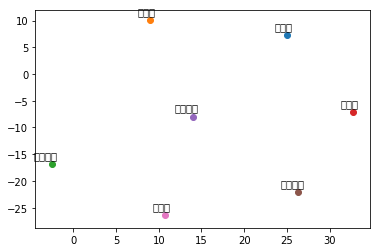

In [19]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [20]:
import matplotlib.font_manager as fm  

In [21]:
path = './NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

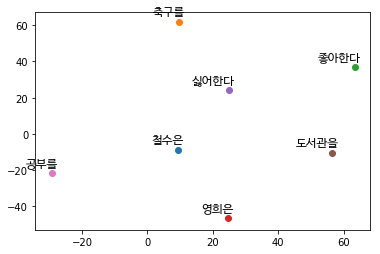

In [22]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()